In [3]:
#installera pandas och matplotlib, 
# och numpy om den inte kommer automatiskt med pandas
import json
import glob
import os
import re
import pandas as pd
import numpy as np
import time
import pprint
import matplotlib.pyplot as plt
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [4]:
#Printar lite extra grejs som kan vara intressant om saker går fel
DEBUG = False

In [5]:
#Genererar ett filträd. Måste ligga i samma mapp som datamapparna
# tree[date][industry][company][handle] är en lista med alla filer för den användaren (alltså: mentions, till, från).  

#TESTAD 19/3, Patrik har kontrollerat att längden på fillistan stämmer överrens med antal jsonfiler och att filnamn
# inte förekommer dubbelt. Koden är testad när notebooken ligger i samma mapp som två datamappar (2020-03-18, 2020-03-19).


tree = {}
INDUSTRIES = ["Airlines"]

#Lista med alla mappar i working directory som heter något i stil med 1111-11-11
collections = [d for d in glob.glob("*") if re.fullmatch(r'[0-9]{4}-[0-9]{2}-[0-9]{2}', d)]

for col in collections:
    tree[col] = {}
    for ind in INDUSTRIES:
        tree[col][ind] = {}
        
        #Den här fångar alla undermappar i /2020-xx-xx/<industry>/
        companies = [os.path.basename(x) for x in glob.glob(os.path.join(col, ind, "*"))]
        
        for comp in companies:
            tree[col][ind][comp] = {}
            
            #Traskar igenom "underfilträdet" för varje företag, alltså med /2020-xx-xx/industry/company/ som root. 
            #Lite snårig men finns bra dokumentation online.
            for root, dirs, files in os.walk(os.path.join(col, ind, comp), topdown=True):
                if dirs:
                    for handle in dirs:
                        tree[col][ind][comp][handle] = []
                else:
                    for f in files:
                        if f.find("tweet") == 0:
                            tree[col][ind][comp][os.path.basename(root)].append(os.path.join(root, f))
                            
#Printar en översikt av hela filträdet
if DEBUG:
    for c in tree.keys():
        print(c)
        for ind in tree[c].keys():
            print('\t', ind)
            for comp in tree[c][ind].keys():
                print('\t\t', comp)
                for handle in tree[c][ind][comp].keys():
                    print('\t\t\t', handle)
                    print('\t\t\t', "antal json:", str(len(tree[c][ind][comp][handle])))
                    for f in tree[c][ind][comp][handle]:
                        print('\t\t\t\t', f)

In [6]:
#Läser in allt i flera DataFrames och skriver ut hur lång tid det tog.
#ITEMS är de fält som tas med. Filtrerar direkt för att spara minne.
ITEMS = ["created_at", "full_text", "id", "id_str", "metadata", "in_reply_to_status_id", "user", "retweeted_status", "in_reply_to_screen_name"]

#dictionary för alla DataFrames
frames = {}

with open("companies_europe.json") as f:
    json_list = json.load(f)[0]["companies"]
    companies = [company["name"] for company in json_list]
for company in companies:
    frames[company] = [] 
t_start = time.time()
for day in tree.keys():
    for company in tree[day]["Airlines"].keys():
        for path in list(tree[day]["Airlines"][company].values())[0]:
            df = pd.read_json(path)
            #Ta bort alla fält som inte finns i items
            df = df.filter(items=ITEMS)
            #Ta bort retweets
            df = df[df["retweeted_status"].isnull()]
            #Skapa en bool-series baserat på språket och behåll endast kolumner där språket känns igen som engelska.
            en = df.metadata.apply(lambda x: x["iso_language_code"] == "en")
            df = df[en]
            #Plocka ut id och screen name från user, de får egna kolumner
            df["user.id"] = df.user.apply(lambda x: x["id"])
            df["user.screen_name"] = df.user.apply(lambda x: x["screen_name"])
            #Lägg till kolumner som anger vilket företag tweeten insamlats från (alltså EJ avsändaren), samt insamlingsdatum
            df["associated_company"]=company
            df["collection_date"]=day
            #Ta bort kolumner vi inte använder
            df = df.drop(["metadata", "user", "retweeted_status"], axis=1)
            #Sätt index till id_str
            df = df.set_index("id")
            #Lägg till i dictionaryt
            frames[company].append(df)
    
print("Time - read files:", time.time()-t_start, "seconds")



Time - read files: 135.97435808181763 seconds
Time - concat: 136.53160119056702 seconds
Tweets: 195091
Memory MB (with duplicates): 353.470675
Tweets (no duplicates): 177857
Time - drop duplicates: 140.404155254364 seconds
Memory MB (no duplicates): 321.696434
Time - add index and adjust columns 144.60633206367493 seconds


In [ ]:
#Styr upp all inläst data.
#Slår ihop alla listor i frames så att varje företag får en egen DataFrame. 
# -Alla tweets i ett företags sammanslagna DataFrame är unika. 
# -Samma tweet kan förekomma i två olika företags DataFrames 
#       (om de tex har taggat flera företag eller svarat ett företag och taggat ett annat)
#Skapar även en DataFrame all_data där alla DataFrames från olika företag slås ihop
# -Alla tweets i all_data är unika.
# -Kolumnen "associated_company" i all_data är alltså oren eftersom tweets som taggar flera företag här endast
#    tillhör det företag som programmet såg först.

#DUPLICATES SYFTAR ALLTSÅ PÅ ATT TWEETS SOM TAGGAR FLERA FÖRETAG RÄKNAS DUBBELT, INTE ATT DE SAMLATS IN DUBBELT

#totala antalet tweets i dictionaryt frames
total_dup = 0
#totala minnesanvändningen för frames + all_data
total_memory = 0
all_data = []
for company in companies:
    #slår ihop alla DataFrames för ett företag till en enda och tar bort dubbelinsamlade tweets för det företaget.
    frames[company] = pd.concat(frames[company])
    frames[company] = frames[company].drop_duplicates(subset="id")
    #Lägger till den framen till all_data
    all_data.append(frames[company])
    
    total_dup += frames[company].shape[0]
    mem = frames[company].memory_usage(index=True, deep=True).sum() / 1000000
    total_memory += mem
    #Skriver ut antalet unika tweets för varje företag och hur mycket minne som går åt (mest för kontroll)
    print(company, "- tweets:", frames[company].shape[0], "- memory:", mem)
#Slår ihop all_data till en frame och tar bort duplicates
all_data = pd.concat(all_data)
all_data = all_data.drop_duplicates(subset="id")
all_data = all_data.set_index("id")
mem = all_data.memory_usage(index=True, deep=True).sum() / 1000000
total_memory+=mem
#Skriver ut totala antalet unika tweets och hur mycket minne all_data tar
print("all_data - tweets:", all_data.shape[0], "-memory:", mem)
#Skriver ut summan av antalet tweets för varje företag, samt totala minnesanvändningen (frames + all_data)
#Se ovan exakt vad som menas med duplicates.
print("total (with duplicates) - tweets:", total_dup, "- memory:", total_memory)

In [ ]:
# Save to csv file
all_data.to_csv('all_data.csv')

In [4]:
# Read csv file
all_data = pd.read_csv("all_data.csv", index_col="id")
all_data.head()

,created_at,full_text,id_str,in_reply_to_status_id,in_reply_to_screen_name,associated_company,iso_language_code,user_id,user_screen_name,sentiment
id,,,,,,,,,,
1240387060902526976,2020-03-18 21:18:15+00:00,"I agree with what you say Gaz, just like they ...",1240387060902526976,NaN,NaN,Flybe,en,761670584350769153,enuffsa1d,0.6239
1240355853531779072,2020-03-18 19:14:14+00:00,RT @ChaplainWEdin: Sad to hear of the situatio...,1240355853531779072,NaN,NaN,Flybe,en,1009255824,CIGBChaplaincy,-0.4767
1240351351479115777,2020-03-18 18:56:21+00:00,Has anyone had a refund back yet from @flybe ?...,1240351351479115776,NaN,NaN,Flybe,en,861615007,JenniRyanXo,0.4122
1240311020028973056,2020-03-18 16:16:05+00:00,https://t.co/WWfcHihpSc\n\nLets not forget our...,1240311020028973056,NaN,NaN,Flybe,en,2330120119,UniteWM7015,-0.1615
1240307787080450048,2020-03-18 16:03:14+00:00,RT @JasonUnsworthAA: While airlines are at ris...,1240307787080450048,NaN,NaN,Flybe,en,1200660601057562624,jetairways2020,-0.5562


In [7]:
#Rekursiv funktion som bygger upp ett dictionary med tweet-id:s baserat på tweet-trådar, konversationer. 
#Varje key är ett id, och varje value är antingen "None", om det inte finns några svar på tweeten, eller ett nytt dictionary med tweetsvarets id som key och antingen "None" eller nytt dictionary som value. Så fortsätter det tills konversationen är slut. 
def build_threads(all_tweets, initial_tweets):
    #Skapar nytt dictionary med key: id och value: None
    subthreads = dict.fromkeys(initial_tweets.index, None) 
    
#För varje tweet i initial_tweets kollas vilka tweets (bland alla tweets) som har med dess id (indexet) i sina in_reply_to-fält. Detta är svar på initial-tweetsen, och sparas i "responses". Så länge responses inte är tom, anropas funktionen igen för att denna gång leta reda på vilka svar som finns på tweetsen i responses. 
    for index in initial_tweets.index:
        if index in subthreads.keys():
            responses = all_tweets[all_tweets.in_reply_to_status_id == index]
            if not responses.empty:
                subthreads[index] = build_threads(tweets, responses)
#Returnerar antingen ett nested dictionary, om det funnits svar, eller ett dictionary med de inskickade tweetsens id som keys och "None" som value. 
    return subthreads

In [8]:
#Konversationträdet byggs upp. 
t_start = time.time()
#Filtrerar bort onödiga kolumner för en något snabbare körning 
tweets = all_data.filter(items=["in_reply_to_status_id"]) 
#Hittar de tweets som påbörjar konversationen
initial_tweets = tweets[tweets.in_reply_to_status_id.isnull()] 
#Bygg trädet! 
threads = build_threads(tweets, initial_tweets)

print("Time - build conversation threads:", time.time()-t_start), "seconds"
print("Antalet konversationer, inkl. de med 0 svar:", len(threads.keys()))
print("Antalet konversationer med > 0 svar:", len([x for x in threads.values() if x is not None]))
print("Memory:", sys.getsizeof(threads)/1000000), "MB")

Time - build conversation threads: 184.1869888305664
Antalet konversationer, inkl. de med 0 svar: 90608
Antalet konversationer med > 0 svar: 13357
Memory: 5.242976


(None, 'MB')

In [9]:
#Skapar en pretty printer för att kunna printa dictionaries, och printar de 100 första twittertrådarna 
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(dict(list(threads.items())[0:100])) 

{   1238824448544948226: None,
    1238863434533527552: None,
    1238879275631226884: {   1238884226914754561: {1238885614998761505: None},
                             1238884746329030657: None,
                             1238884932216389640: {   1238886079140429825: {   1238886373660164098: {   1238891392635731968: {   1238893271197286409: None}}}}},
    1238879476857155584: None,
    1238899135409016833: {1239599823873081345: None},
    1238906624695205888: None,
    1238907070881107969: None,
    1238926947608080386: None,
    1238934990601302017: None,
    1238944454804996096: None,
    1238961950161240066: None,
    1238963632710582275: {   1238963870678552576: None,
                             1239575150141546496: None,
                             1239648808310648832: None},
    1238967065383444480: None,
    1238969081006563328: None,
    1238999014277775366: None,
    1239009249663090688: None,
    1239040290947809280: None,
    1239105083071254529: None,
    123910749139

In [ ]:
#Funktion för att rensa tweettexten som ska användas i sentimentanalysen på onödiga symboler
def clean(tweet_str):
    #Rensar bort RT - symboliserar att det är en retweet
    tweet_str = re.sub(r'RT[\s]+', '', tweet_str)
    #Rensar bort länkar
    tweet_str = re.sub(r'https?:\/\/.*[\r\n]*','',tweet_str)
    #Rensar bort hashtags
    tweet_str = re.sub(r'#', '', tweet_str)
    return tweet_str

In [ ]:
#Funktion som analyserar och returnerar sentimentet för en tweet
def analyse_sentiment(tweet_str):
    #Rensar bort onödiga symboler
    clean_tweet = clean(tweet_str)
    #Skapar objektet som utför sentimentanalysen
    analyzer = SentimentIntensityAnalyzer()
    #Analyserar sentimentet
    sentiment = analyzer.polarity_scores(clean_tweet)
    #Returnerar det sammanställda sentimentet, där både positivt, negativt och neutralt sentiment har räknats in samt eventuella ord/punktuationer/liknande som förstärker känslan åt något håll.
    return sentiment["compound"]

In [ ]:
#Går igenom alla tweets och anropar funktion för att anlysera dess sentiment, vilket läggs till som en ny kolumn i dataframen all_data. OBS: Tar lång tid, ca 35-45 min för ~180000 tweets.  
t_start = time.time()
all_data["sentiment"] = all_data.full_text.apply(lambda x: analyse_sentiment(x))
print("Time - analys av sentiment:", (time.time()-t_start)/60, "min")

In [39]:
#Uppdatera csv filen
all_data.to_csv('all_data.csv')

In [5]:
#Dataframe med tweets grupperade efter företag och datum, med avg sentiment för varje datum. 

#Kopierar datan till en ny df 
mean_sentiment= all_data.copy()
#Gör om tiden till specifika datum. Kan behöva kommenteras bort om redan körd en gång
mean_sentiment["created_at"] = pd.to_datetime(mean_sentiment['created_at']).dt.to_period("D") 
#Grupperar datan efter företag och datum, samt beräknar avg sentiment. 
mean_sentiment=mean_sentiment.groupby(['associated_company','created_at'])['sentiment'].mean()


Text(0.5,1,'')

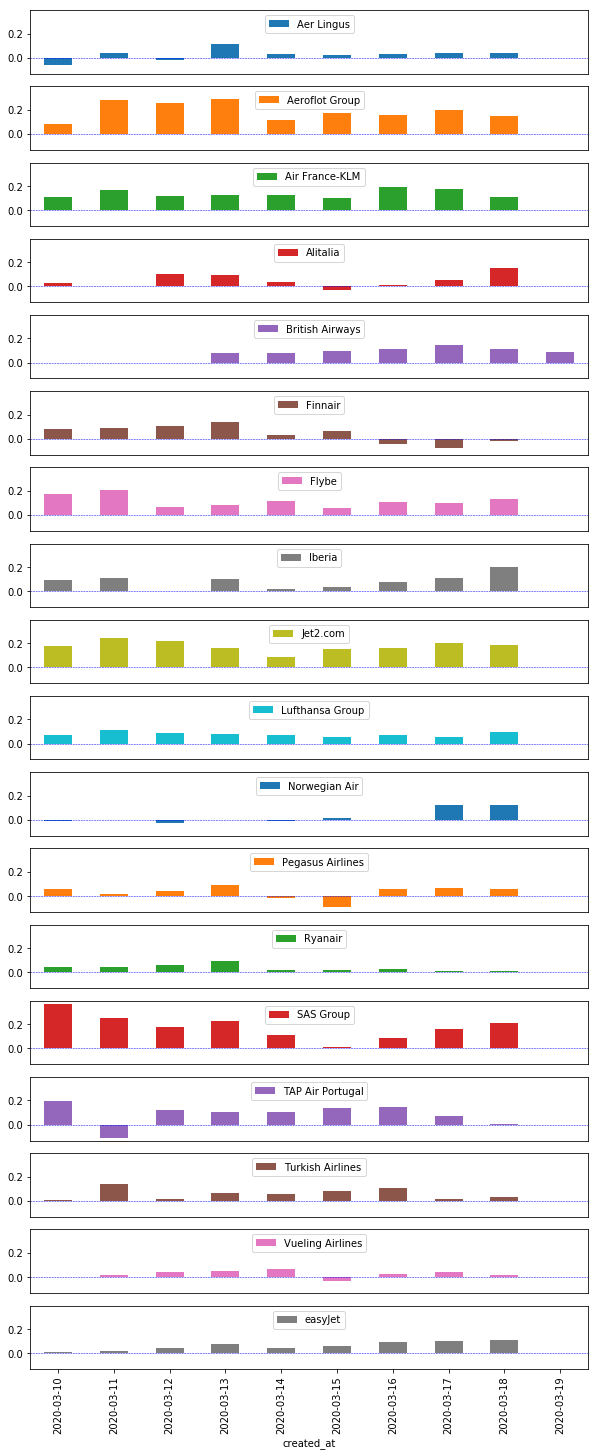

In [6]:
#Plotta avg sentimentet för varje datum och företag

fig, axes = plt.subplots(18, sharey=True, figsize=(10,25))

mean_sentiment.unstack(level=0).plot(kind='bar', subplots=True, ax=axes)

for ax in axes[:-1]:
    ax.set_xticks([]) 
    ax.set_xlabel('') 
    ax.set_title('')
    ax.axhline(linewidth=0.5, color='b',ls='--' )
    ax.legend(loc=9) 

axes[-1].legend(loc=9) 
axes[-1].axhline(linewidth=0.5, color='b',ls='--' )
axes[-1].set_title('')

In [7]:
#          Dataframe där all analysdata läggs in
#------------------------------------------------------------------------

# KOLUMNER: 

#avg_sentiment = det genomsnittliga sentimentet av alla tweets relaterade till ett företag för ett specifikt datum.

#avg_customer_tweet_sentiment = det genomsnittliga sentimentet av kunders initialtweets riktade till ett företag, för ett specifikt datum 
#customer_tweet_count = antalet initiala tweets riktade till företaget

#avg_customer_reply_sentiment = det genomsnittliga sentimentet av trådskaparens svar på ett företags svar, för ett specifikt datum
#avg_customer_change = den genomsnittliga förändringen i sentimentet från kundens första tweet, till dess svar på företagets svar
#customer_reply_count = antalet svar gjorda av trådskaparen, på företagsvar av deras initialtweet
#customer_tweet_std = standardavvikelsen för sentimentet på kunders initialtweets 
#customer_reply_std = standardavvikelsen för sentimentet på trådskaparens svar på företagssvar

#(Denna är lite rörig, vet inte riktigt vad jag själv menar med företagstweets - om det är företags initiala tweets eller företagssvar på kunders tweets eller båda två)
#avg_customers_replies_sentiment = det genomsnittliga sentimentet av alla kunders svar på ett företags tweet, för ett specifikt datum
#avg_customers_change = den genomsnittliga skillnaden på kunders initiala tweet och allas svar på företagstweets
#customer_replies_count = analet kundsvar gjorda på företagstweets 
#customer_replies_std = standardavvikelsen för sentimentet på svar på företagstweets

#avg_company_tweet_sentiment = genomsnittligt sentiment av företags initialtweets
#avg_company_reply_sentiment = genomsnittligt sentiment av företagssvar på kunders tweets
#company_tweets_count = antalet initialtweets gjorde av ett företag
#company_replies_count = antalet företagssvar på kunder tweets
#company_replies/customer_tweets = antalet företagssvar per kunders initialtweets
#avg_company_reply_time = genomsnittlig svarstid för företag på kunders tweets 

COLUMNS = ["date", "company", "avg_sentiment", "avg_customer_tweet_sentiment", "customer_tweet_count", "customer_tweet_std", "avg_customer_reply_sentiment", "avg_customer_change", "customer_reply_count", "customer_reply_std", "avg_customers_replies_sentiment", "avg_customers_change", "customers_replies_count",   "customers_replies_std", "company_tweet_sentiment", "company_reply_sentiment","company_tweets_count", "company_replies_count", "company_replies/customer_tweets", "avg_company_reply_time"]

analysed_data = pd.DataFrame(columns=COLUMNS)